# Similarités entre séries ( Word Embeddings )

#### - utilisation de word embeddings avec tf-idf pour trouver une mesure de similarité entre les différentes séries

## Principe

Dans ce qui suis nous utiliserons le terme "Document" pour dire "Série". Vu que l'on considère une série comme la concaténation de tous les sous titres de tous ses épisodes, et donc comme un long document.

Pour le calcul de similarité entre les documents, nous allons suivre la même méthode qu'avant :
- représenter un document par un vecteur
- utiliser des mesures de distance pour calculer la similarité entre deux vecteurs ( deux documents )

Ceci servira comme base pour faire un clustering de "genre" ou de "style" des documents.
Nous allons pour un début tester juste une combinaison de possibilités:
- démarrer à partir des vecteurs tf-idf des documents
- vecteurs word embedding généré par Word2vec
- distance de mesure : cosinus

### Word embedding ? 
Pour le définir rapidement, on peut dire que pour chaque mot du corpus on va avoir un vecteur de réels de taille fixe qui représentera d'une manière ou d'une autre le mot.

Et comme par magie des opérations vectoriels entre des mots ( vecteurs de réels ) nous donnes des mesures de similarités plutot correctes ! au lieu d'utiliser simplement tf-idf qui sont des vecteurs sparse.

Pour générer ces vecteurs nous allons utiliser Word2Vec entrainé sur le corpus entier, c'est à dire un gros fichier text qui contient l'ensemble des mots de tout le corpus.

### Document embedding ?
D'accord on a une représentation vectorielle de chaque mot qui marche comme par magie, mais nous souhaterions avoir une représentation similaire pour chaque document ( afin de mesurer cette similarité par magie aussi ).

Pour cela nous allons utiliser un simple principe:
- Soit V le vecteur représentant un Document lambda ( que ça soit tf-idf par exemple ) de taille N  (N = nombre de mots du vocabulaire ) 
- Soit la taille fixe du vecteur word embedding = p
- Soit la matrice M = N x p , càd N lignes ( N = nombre de mots du vocabulaire ) et p colonnes, ou chaque ligne i est le vecteur word embedding obtenu à partir de word2vec correspondant au ieme mot du vocabulaire
- Le vecteur D représentant le document embedding sera donc simplement :  D = V.M ( biensure on va s'arranger pour que la multiplication se passe bien en alignant les bonnes dimensions )

pour faire facile : le document sera la somme des word embeddings des mots qui le composent ( pondéré par tf-idf dans notre cas )


#### préparation de l'environnement de travail
Avec définition du nombre de séries que l'on veut étudier

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import seaborn as sns
#using https://github.com/amueller/word_cloud
from wordcloud import WordCloud

from utils.load_data import getMostImportantSeries

plt.style.use('seaborn-white')
%matplotlib inline

#dataset path
path = "/root/Documents/PLDAC/data"
#repertoir pour stocker les calculs de word2vec
w2vPath = "/root/Documents/PLDAC/Word2VecData/"
#nombre de series que l'on veut étudier
nbSeries = 42

Petit affichage des séries que l'on étudie

In [3]:
seriesNames, epCount = getMostImportantSeries(path, byepisodes=True)
series = seriesNames[:nbSeries]
#series

Définition d'une petite fonction qui va juste enlever la ponctuation de chaque épisode et enlever les stop words ainsi que les mots trop longs ( oui on a pas fait de stemming ou lemmatizing pour ce test )

In [4]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
nltk_stopw = stopwords.words('english')

def tokenize_ex(text):
    #   no punctuation & starts with a letter & between 3-15 characters in length
    tokens = [word.strip(string.punctuation) for word in RegexpTokenizer(r'\b[a-zA-Z][a-zA-Z0-9]{2,14}\b').tokenize(text)]
    return [f.lower() for f in tokens if f and f.lower() not in nltk_stopw]

""" TOKENIZE FUNCTION SIGNATURE """
# in : du texte brut ( un long str )
# out : une liste de tokens ( liste de str )
# remplacer par une autre fonction personalisé
# cette fonction s'occupe des stop words, stemming, lemmatizing ... 
# bref tout ce qu'il faut faire comme normalisation du texte
tokenize = tokenize_ex

### Construction du corpus
Et hop ! on se construit un joli corpus à partir des séries choisies. En utilisant un itérateur pour être gentil en mémoire.

- WordTrainer : construit un itérateur, qui parcours les textes des séries

In [5]:
class WordTrainer(object):
    def __init__(self, path, series):
        self.path = path
        self.series = series
    def __iter__(self):
        for serie in self.series:
            listepisodes = glob.glob(self.path+"/"+serie+"/*/*.lines")
            for episode in listepisodes:
                with open(episode, "r", encoding="utf-8") as file:
                    tokenized = tokenize(file.read())
                    yield tokenized

series_yeilded = WordTrainer(path, series)

### Préparation de word2vec

On utilisera la version Word2vec de Gensim, avec la possibilité de charger un model pré-entrainé auparavant

In [6]:
import gensim

# Charger un model déjà pret ?
load = False
filename_model_load = 'gensim_model_'+str(nbSeries)
filename_model_save = 'gensim_model_'+str(nbSeries)
# Parametres du word2vec
vec_size = 100
word_window = 8
word_count_min = 5

### Train de word2vec / chargement

In [7]:
# this line also trains the model, so brace yourselves for the waiting time
if not load:
    word_vector_model = gensim.models.Word2Vec(series_yeilded, size=vec_size, window=word_window, min_count=word_count_min)
else:
    word_vector_model = gensim.models.Word2Vec.load(w2vPath+filename_model_load)

### Sauvegarde du model

In [8]:
word_vector_model.save(w2vPath+filename_model_save)

Petit teste rapide pour voir si le tout a bien fonctionné

In [9]:
word_vector_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('queen', 0.6841282248497009)]

#### Visualisation  des dimensions

In [10]:
word_vector_model.wv.vectors.shape

(60124, 100)

## Préparation des tokens de chaque document
Dans le but de préparer les calculs pour la matrice de similarités ultérieurement

- **built_corpus_tokens** : construit un itérateur qui parcours tout le corpus, et rends pour chaque série une liste de tokens

In [11]:
def build_corpus_tokens():
    for serie in series:
        listepisodes = glob.glob(path+"/"+serie+"/*/*.lines")
        serie_tokens = []
        for episode in listepisodes:
            with open(episode, "r", encoding="utf-8") as file:
                tokenized = tokenize(file.read())
                serie_tokens += tokenized
        yield np.array(serie_tokens)

Initialisation de l'itérateur

In [12]:
l = build_corpus_tokens()

### Construction du vecteur document ( série )
On construit un vecteur qui représente une série selon une norme ( TF-IDF par exemple ).

Au final on obtien une matrice ( chaque ligne représente une série ).

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

""" analyzer function """
# analyzer : string, {‘word’, ‘char’, ‘char_wb’} or callable
# Whether the feature should be made of word or character n-grams. 
#Option ‘char_wb’ creates character n-grams only from text inside word boundaries; n-grams at the edges
#of words are padded with space.
# If a callable is passed it is used to extract the sequence of features out of the raw, unprocessed input.
analyzer_ = lambda x: x

# minimum document frequency
min_docu_freq = 1

vectorizer = TfidfVectorizer(analyzer=analyzer_, min_df=min_docu_freq).fit(l)

In [14]:
""" Custom Vectorizer """
# pour faire un constructeur de vecteurs documents :
# in :
# s'assurer qu'il prend l'itérateur sur les séries, pour rester memory friendly
# c'est à dire il prend en entrée toujours un itérateur et non pas une liste
# out :
#  word_index :
#      A mapping of terms to feature indices. ( dictionnaire : clé = mot, valeur = indice dans la colonne du vecteur )
#  Xencoded : 
#      document-term matrix ( matrice : lignes = docs, colonnes = mots de word_index)
#      en gros chaque case[i,j] correspond au nombre ( int ? float ? ) qu'on associe au mot j dans le document i

# Après il suffit de remplacer les variables word_index et Xencoded par les versions désirées

' Custom Vectorizer '

réinitialisation de l'itérateur pour le réutiliser

In [15]:
l = build_corpus_tokens()

#### Organisation de la matrice pour faire le produit matriciel ultérieurement

In [16]:
word_index = vectorizer.vocabulary_
Xencoded = vectorizer.transform(l)

En se basant sur word_index ( liste des mots tf-idf, question d'avoir le meme ordre de tri )

Dans la matrice résultante de **getEmbeddingMatrix**: 

- si un mot n'existe pas dans les word embedding on met un vecteur nul.
- sinon on met le vecteur word embedding qui correspond.

In [17]:
def getEmbeddingMatrix (word_index, embeddings):
    embedding_matrix = np.zeros((len(word_index)+1, vec_size))
    for word, i in word_index.items():
        if word in embeddings:
            embedding_matrix[i] = embeddings[word]
    return embedding_matrix

### Produit Matriciel entre la matrice tf-idf et la matrice embedding
Dans notre exemple on fait une combinaison plutot simple entre le word embedding et le vecteur document:

- On prend les vecteurs embedding de chaque mot présent dans le document
- On pondère le vecteur par son coéfficient tf-idf correspondant
- On fait la somme des vecteurs obtenus
- On considère le vecteur obtenu comme le vecteur 'embedding' du document

Bien sure il va falloir tester d'autres alternatives aussi

In [18]:
""" Custom Doc Representation """
# Il suffit de trouver une combinaison entre les données qu'on a ( tf-idf, tf, embedding de mots ... )
# il n'y a pas de limites soyez créatifs xD
# out : construire une matrice ou chaque ligne correspond à un document, 
#       et tel que la ligne est un vecteur de taille vec_size
#       il faut bien sure faire attention à préserver l'ordre des documents


def sparseMultiply (sparseX, embedding_matrix):
    denseZ = []
    for row in sparseX:
        newRow = np.zeros(vec_size)
        for nonzeroLocation, value in list(zip(row.indices, row.data)):
            newRow = newRow + value * embedding_matrix[nonzeroLocation]
        denseZ.append(newRow)
    denseZ = np.array([np.array(xi) for xi in denseZ])
    return denseZ

In [19]:
# création de la matrice embedding à partir du model word2vec
embedding_matrix = getEmbeddingMatrix (word_index, word_vector_model)
# produit matriciel entre cette matrice et les tf-idf
Xencoded = sparseMultiply( Xencoded, embedding_matrix)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


### Resultat
Comme on le voulait, une matrice qui représente chaque document par un vecteur embedding de taille fixe ( on obtient une toute petite matrice au final donc les calculs sont plutot rapides ) 

In [20]:
Xencoded.shape

(42, 100)

Comparé à la matrice qui contient tous les mots du corpus, on a bien réduit les dimensions

In [21]:
word_vector_model.wv.vectors.shape

(60124, 100)

## Visualisation des résultats obtenus
ENFIN ! on fait juste un calcul de similarité de cosinus entre chaque pair de documents et le tour est joué !

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

""" Similarity Measure """
# Eh beeeh rien à expliquer de spécial
# in : Xencoded ( qui à ce niveau du code à été écrasé par le sparseMultiply et représente donc la 
#          nouvelle représentation matricielle du corpus, chaque ligne correspond toujours à un document,
#          sauf que maintenant au lieu d'avoir une colonne représente un mot, on a un truc abstrait dans chaque
#          colonne, càd chaque document est représenté par un vecteur de nombres ( int ? float ? ) mais qui n'a
#          pas forcément un sense compréhensible directement par nous )
# out : matrice carré de similarités entre chaque couple de documents ( case[i,j] = similarité entre doc i et doc j )
# Bieeensure préserver l'ordre des documents

sim = cosine_similarity(Xencoded)

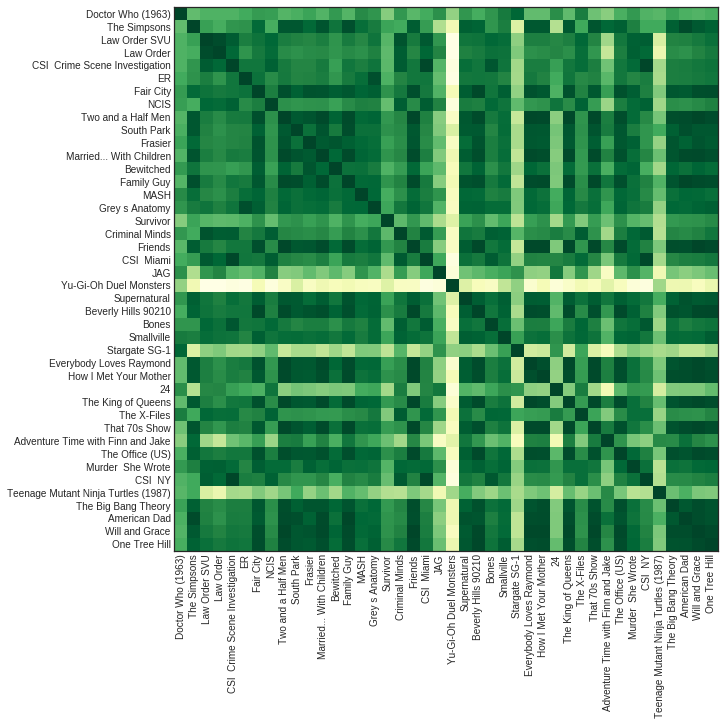

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(sim, cmap='YlGn', interpolation='nearest')
plt.xticks(range(len(series)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.yticks(range(len(series)), [" ".join(x.split("_")[1:]) for x in series])
plt.show()

### Sauvegarde de la matrice de similarités

In [24]:
np.save(w2vPath+'sim_'+str(nbSeries)+'.npy', sim)

# Observations
De première vue les résultats semblent meilleures que juste l'utilisation de tf-idf, les word embedding ont vraiment apporté plus d'information aux vecteurs documents.

On remarque que "The Simpsons" est bien proche de "South Park" , "Family Guy" et "Married... With Children"

EH BEEH c'est super ça :D !

## Quelques tests
Nous avons calculé les similarités pour 3000 séries et on peut essayer de voir si les résultats semblent plutot cohérents juste par rapport à la similarité.

On affiche donc les 10 séries les plus similaires à quelques séries connues pour voir si la similarité à l'air de donner de bon résultats.

In [25]:
# chargement de la matrice de similarités de 3000 séries
sim_load = 'sim_3000.npy'
sim = np.load(w2vPath+sim_load)

# chargement des listes de noms
seriesNames, epCount = getMostImportantSeries(path, byepisodes=True)
series = seriesNames[:3000]

On se sert de ce bout de code pour chercher l'id d'une série dans notre matrice de similarités, à partir d'un sous mot de son nom

In [39]:
# mot clé à chercher dans le nom de la série, pour obtenir l'id de la série dans la matrice
ssMot = "brooklyn"
matching = [(s,i) for i,s in enumerate(series) if ssMot.lower() in s.lower()]
matching

[('880_Brooklyn_Nine-Nine', 414),
 ('3260_Taxi_Brooklyn', 1415),
 ('1536_Brooklyn_DA', 2989)]

In [27]:
# id de la série choisie
serie_ = 0
# le nombre de séries similaires à afficher
nbOfSims = 10
# Affichage des séries les plus similaires par ordre décroissant
similar_idx = np.array(np.argsort(sim[serie_])[-nbOfSims-1:-1])
s = np.array(series)
print("Chosen Serie : "+series[serie_])
print("Similar to :")
res = list(s[similar_idx])[::-1]
print(*res, sep='\n')

Chosen Serie : 411_Doctor_Who_(1963)
Similar to :
1921_Lost_in_Space
2342_The_Outer_Limits_(1963)
2339_Doctor_Who
2929_Logan_s_Run
441_Out_of_the_unknown
2673_Quatermass_II
2215_Crusade
2886_Buck_Rogers_in_the_25th_Century
2056_Planet_of_the_Apes
1364_Stargate_Atlantis


### Quelques séries célèbres et leurs similarités

In [40]:
series_celebre = [("411_Doctor_Who_(1963)", 0),('1576_How_I_Met_Your_Mother', 28),('2289_Game_of_Thrones', 346),
                  ('2441_Friends', 18),('1095_The_Simpsons', 1),('6_Yu-Gi-Oh_Duel_Monsters', 21),
                  ('3160_Star_Trek__Voyager', 57),('2753_Rick_and_Morty', 896),('2540_The_Vampire_Diaries', 92),
                  ('1922_House', 51),('1039_CSI__Crime_Scene_Investigation', 4),('2293_Shameless_(US)', 339),
                  ('1286_Smallville', 25),('880_Brooklyn_Nine-Nine', 414)]

nbOfSims = 10

for nom, idx in series_celebre:
    # Affichage des séries les plus similaires par ordre décroissant
    similar_idx = np.array(np.argsort(sim[idx])[-nbOfSims-1:-1])
    s = np.array(series)
    print("Chosen Serie : "+nom)
    print("Similar to :")
    res = list(s[similar_idx])[::-1]
    print(*res, sep='\n')
    print("\n")

Chosen Serie : 411_Doctor_Who_(1963)
Similar to :
1921_Lost_in_Space
2342_The_Outer_Limits_(1963)
2339_Doctor_Who
2929_Logan_s_Run
441_Out_of_the_unknown
2673_Quatermass_II
2215_Crusade
2886_Buck_Rogers_in_the_25th_Century
2056_Planet_of_the_Apes
1364_Stargate_Atlantis


Chosen Serie : 1576_How_I_Met_Your_Mother
Similar to :
2371_Weird_Loners
1415_Better_With_You
1223_Marry_Me
297_What_I_Like_About_You
2444_Mad_Love
1715_100_Questions
174_Modern_Family
3170_Love_Bites
2441_Friends
1271_Perfect_Couples


Chosen Serie : 2289_Game_of_Thrones
Similar to :
2257_Camelot
1542_The_Dovekeepers
1719_Vikings
583_The_Last_Kingdom
1033_Rome
3168_Roman_Mysteries
61_Atlantis_(2013)
1280_Robin_Hood
2964_The_Bastard_Executioner
3024_Kung_Fu


Chosen Serie : 2441_Friends
Similar to :
1408_Will_and_Grace
357_Samantha_Who_
657_What_About_Brian
3056_Related
2140_Friends_with_Better_Lives
2444_Mad_Love
1992_Melissa_Joey
1152_Sean_Saves_The_World
1415_Better_With_You
174_Modern_Family


Chosen Serie : 1095_T

### perspectives
Il faut experimenter avec d'autres combinaisons :
- différentes représentations de base d'un document ( Count, Tf, Tf-idf ... ) 
- différents prétraitements : stemming, lemmatizing, subsampling ...
- différentes mesures de similarité : Euclidian distance, Jaccard ...

Voir même entrainer les word embeddings sur un corpus plus gros ( ça pourrait prendre du temps, mais on le fait une fois pour toute )